<a href="https://colab.research.google.com/github/guscassiano/Dio_ML_bootcamp/blob/face_detection/Face_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Instalação das Bibliotecas

Este bloco instala todas as bibliotecas necessárias para o sistema de reconhecimento facial:

- **TensorFlow**: Framework de machine learning para criar o modelo
- **MediaPipe**: Biblioteca do Google para detecção rápida de faces
- **OpenCV**: Processamento de imagens e visão computacional  
- **scikit-learn**: Ferramentas para machine learning (divisão de dados, métricas)
- **Matplotlib**: Visualização dos resultados

⚠️ **Execute apenas uma vez no início do notebook**

In [1]:
!pip install mediapipe tensorflow opencv-python matplotlib numpy pillow
!pip install mtcnn tensorflow-addons

  Using cached mtcnn-1.0.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached lz4-4.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached mtcnn-1.0.0-py3-none-any.whl (1.9 MB)
Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
Using cached lz4-4.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.

## Importação das libs necessárias e validação das mesmas

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import requests
from io import BytesIO
import zipfile
import gdown

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)


TensorFlow version: 2.19.0
OpenCV version: 4.11.0


# 🎯 Classes do Sistema de Reconhecimento

O sistema é dividido em 3 classes principais:

## 🔍 **FaceDetector**
- **Função**: Encontra faces nas imagens usando MediaPipe
- **Vantagem**: Muito rápido e preciso
- **Saída**: Coordenadas das faces + nível de confiança

## 🧠 **FaceEmbeddingRecognizer**
- **Função**: Reconhece quem é cada face detectada
- **Técnica**: Usa embeddings (representações matemáticas) das faces
- **Diferencial**: Funciona bem mesmo com poucas fotos por pessoa

## 🎛️ **SmallDatasetFaceSystem**
- **Função**: Combina detecção + reconhecimento
- **Especialidade**: Otimizado para datasets pequenos (1-5 fotos por pessoa)
- **Extra**: Faz aumento de dados automaticamente

In [3]:
class FaceDetector:
    def __init__(self, min_detection_confidence=0.7, min_tracking_confidence=0.5):
        self.mp_face_detection = mp.solutions.face_detection
        self.mp_drawing = mp.solutions.drawing_utils

        self.face_detection = self.mp_face_detection.FaceDetection(
            min_detection_confidence=min_detection_confidence
        )

    def detect_faces(self, image):
        """
        Detecta faces em uma imagem usando MediaPipe
        """
        # Converte BGR para RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Processa a imagem
        results = self.face_detection.process(rgb_image)

        faces = []
        if results.detections:
            h, w, c = image.shape

            for detection in results.detections:
                # Obtém as coordenadas da bounding box
                bbox = detection.location_data.relative_bounding_box

                # Converte para coordenadas de pixel
                x = int(bbox.xmin * w)
                y = int(bbox.ymin * h)
                width = int(bbox.width * w)
                height = int(bbox.height * h)

                # Extrai a face
                face = image[y:y+height, x:x+width]

                faces.append({
                    'face': face,
                    'bbox': (x, y, width, height),
                    'confidence': detection.score[0]
                })

        return faces

    def draw_detections(self, image, faces):
        """
        Desenha as detecções na imagem
        """
        annotated_image = image.copy()

        for face_data in faces:
            x, y, w, h = face_data['bbox']
            confidence = face_data['confidence']

            # Desenha retângulo
            cv2.rectangle(annotated_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Adiciona texto com confiança
            text = f"Face: {confidence:.2f}"
            cv2.putText(annotated_image, text, (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        return annotated_image

MODELO DE RECONHECIMENTO FACIAL

In [4]:
class FaceRecognizer:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = None
        self.label_encoder = LabelEncoder()
        self.is_trained = False

    def create_model(self, num_classes):
        """
        Cria o modelo usando transfer learning com MobileNetV2
        """
        # Base model pré-treinada
        base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        # Congela as camadas da base
        base_model.trainable = False

        # Adiciona camadas customizadas
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

        # Compila o modelo
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def preprocess_face(self, face):
        """
        Preprocessa uma face para o modelo
        """
        if face.size == 0:
            return None

        # Redimensiona para o tamanho esperado
        face_resized = cv2.resize(face, self.input_shape[:2])

        # Normaliza os pixels
        face_normalized = face_resized.astype('float32') / 255.0

        return face_normalized

    def train(self, faces_data, labels, epochs=20, batch_size=32):
        """
        Treina o modelo com os dados fornecidos
        """
        if len(faces_data) == 0:
            print("Erro: Nenhum dado de treino fornecido!")
            return

        # Preprocessa as faces
        processed_faces = []
        valid_labels = []

        for face, label in zip(faces_data, labels):
            processed_face = self.preprocess_face(face)
            if processed_face is not None:
                processed_faces.append(processed_face)
                valid_labels.append(label)

        if len(processed_faces) == 0:
            print("Erro: Nenhuma face válida encontrada!")
            return

        # Converte para numpy arrays
        X = np.array(processed_faces)
        y = np.array(valid_labels)

        # Codifica as labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Cria o modelo
        num_classes = len(self.label_encoder.classes_)
        self.create_model(num_classes)

        print(f"Treinando modelo com {len(X)} imagens e {num_classes} classes...")
        print(f"Classes: {self.label_encoder.classes_}")

        # Verifica se há dados suficientes para divisão
        if len(X) < 4:  # Muito poucos dados para divisão
            print(f"⚠️  Poucos dados ({len(X)} amostras). Treinando sem validação.")

            # Treina com todos os dados
            history = self.model.fit(
                X, y_encoded,
                batch_size=min(batch_size, len(X)),
                epochs=epochs,
                verbose=1
            )

            print("\n✅ Modelo treinado com dataset pequeno")
            print("💡 Adicione mais imagens por pessoa para melhor performance!")

        else:
            # Divide em treino e validação apenas se tiver dados suficientes
            test_size = min(0.2, 1/len(X))  # Pelo menos 1 amostra para validação

            X_train, X_val, y_train, y_val = train_test_split(
                X, y_encoded, test_size=test_size, random_state=42,
                stratify=y_encoded if len(np.unique(y_encoded)) > 1 else None
            )

            # Treina o modelo
            history = self.model.fit(
                X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                verbose=1
            )

            # Avaliação
            val_predictions = self.model.predict(X_val)
            val_pred_classes = np.argmax(val_predictions, axis=1)
            accuracy = accuracy_score(y_val, val_pred_classes)

            print(f"\nAcurácia no conjunto de validação: {accuracy:.4f}")
            print("\nRelatório de classificação:")
            print(classification_report(y_val, val_pred_classes,
                                       target_names=self.label_encoder.classes_))

        self.is_trained = True

        return history

    def predict(self, face):
        """
        Reconhece uma face
        """
        if not self.is_trained or self.model is None:
            return "Modelo não treinado", 0.0

        processed_face = self.preprocess_face(face)
        if processed_face is None:
            return "Face inválida", 0.0

        # Adiciona dimensão do batch
        face_batch = np.expand_dims(processed_face, axis=0)

        # Faz a predição
        predictions = self.model.predict(face_batch, verbose=0)
        confidence = np.max(predictions)
        predicted_class_idx = np.argmax(predictions)

        # Decodifica a label
        predicted_class = self.label_encoder.inverse_transform([predicted_class_idx])[0]

        return predicted_class, confidence

    def save_model(self, filepath):
        """
        Salva o modelo e o label encoder
        """
        if self.model is not None:
            self.model.save(f"{filepath}_model.h5")

            # Salva o label encoder
            with open(f"{filepath}_encoder.pkl", 'wb') as f:
                pickle.dump(self.label_encoder, f)

            print(f"Modelo salvo em: {filepath}_model.h5")
            print(f"Label encoder salvo em: {filepath}_encoder.pkl")

    def load_model(self, filepath):
        """
        Carrega o modelo e o label encoder
        """
        try:
            self.model = tf.keras.models.load_model(f"{filepath}_model.h5")

            # Carrega o label encoder
            with open(f"{filepath}_encoder.pkl", 'rb') as f:
                self.label_encoder = pickle.load(f)

            self.is_trained = True
            print("Modelo carregado com sucesso!")

        except Exception as e:
            print(f"Erro ao carregar modelo: {e}")


SISTEMA COMPLETO DE RECONHECIMENTO

In [5]:
class FaceRecognitionSystem:
    def __init__(self):
        self.detector = FaceDetector()
        self.recognizer = FaceRecognizer()

    def process_image(self, image_path_or_array, show_results=True):
        """
        Processa uma imagem completa - detecta e reconhece faces
        """
        # Carrega a imagem
        if isinstance(image_path_or_array, str):
            image = cv2.imread(image_path_or_array)
        else:
            image = image_path_or_array.copy()

        if image is None:
            print("Erro: Não foi possível carregar a imagem!")
            return None

        # Detecta faces
        faces = self.detector.detect_faces(image)

        # Reconhece cada face
        results = []
        annotated_image = image.copy()

        for face_data in faces:
            face = face_data['face']
            bbox = face_data['bbox']

            # Reconhece a face
            if self.recognizer.is_trained:
                name, confidence = self.recognizer.predict(face)

                # Desenha resultado
                x, y, w, h = bbox
                color = (0, 255, 0) if confidence > 0.7 else (0, 165, 255)

                cv2.rectangle(annotated_image, (x, y), (x+w, y+h), color, 2)

                text = f"{name}: {confidence:.2f}"
                cv2.putText(annotated_image, text, (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                results.append({
                    'name': name,
                    'confidence': confidence,
                    'bbox': bbox
                })
            else:
                # Apenas detecção
                x, y, w, h = bbox
                cv2.rectangle(annotated_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(annotated_image, "Face detectada", (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if show_results:
            plt.figure(figsize=(12, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Imagem Original')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Faces Detectadas: {len(faces)}')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return {
            'original_image': image,
            'annotated_image': annotated_image,
            'results': results,
            'num_faces': len(faces)
        }

FUNÇÕES AUXILIARES PARA COLETA DE DADOS

📂 Como Organizar suas Imagens

Antes de treinar o modelo, organize suas fotos assim:

dataset/
├── pessoa1/          ← Nome da primeira pessoa
│   ├── foto1.jpg
│   ├── foto2.jpg
│   └── foto3.jpg
├── pessoa2/          ← Nome da segunda pessoa
│   ├── foto1.jpg
│   └── foto2.jpg
└── artista_x/        ← Nome do terceiro pessoa
├── show1.jpg
└── show2.jpg

EXEMPLO DE USO:

In [6]:
def create_training_dataset():
    """
    Função para criar um dataset de treino a partir de imagens
    Você deve organizar suas imagens em pastas com o nome da pessoa
    """
    print("Para treinar o modelo, organize suas imagens da seguinte forma:")
    print("dataset/")
    print("├── pessoa1/")
    print("│   ├── foto1.jpg")
    print("│   ├── foto2.jpg")
    print("│   └── ...")
    print("├── pessoa2/")
    print("│   ├── foto1.jpg")
    print("│   └── ...")
    print("└── ...")

    dataset_path = input("Digite o caminho para o dataset (ou pressione Enter para usar './dataset'): ")
    if not dataset_path:
        dataset_path = './dataset'

    if not os.path.exists(dataset_path):
        print(f"Criando diretório: {dataset_path}")
        os.makedirs(dataset_path)
        print("Adicione suas imagens organizadas por pastas e execute novamente.")
        return None, None

    faces_data = []
    labels = []
    detector = FaceDetector()

    # Percorre cada pasta (classe)
    for person_name in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_name)

        if not os.path.isdir(person_path):
            continue

        print(f"Processando imagens de: {person_name}")

        # Percorre cada imagem da pessoa
        for image_file in os.listdir(person_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(person_path, image_file)

                # Carrega a imagem
                image = cv2.imread(image_path)
                if image is None:
                    continue

                # Detecta faces
                faces = detector.detect_faces(image)

                # Adiciona cada face detectada
                for face_data in faces:
                    faces_data.append(face_data['face'])
                    labels.append(person_name)

        print(f"  - Encontradas {len([l for l in labels if l == person_name])} faces")

    print(f"\nTotal de faces coletadas: {len(faces_data)}")
    print(f"Classes encontradas: {set(labels)}")

    return faces_data, labels

def download_sample_images():
    """
    Baixa imagens de exemplo para teste (celebridades famosas)
    """
    print("Baixando imagens de exemplo...")

    # Cria diretório
    if not os.path.exists('sample_images'):
        os.makedirs('sample_images')

    # URLs de imagens de exemplo (domínio público) - Usando URLs mais confiáveis
    sample_urls = {
        'test_image_1.jpg': 'https://upload.wikimedia.org/wikipedia/commons/f/ff/Google-Labs-Logo.wine.png', # Using a different image for testing
        'test_image_2.jpg': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Google_logo_2013.svg/1200px-Google_logo_2013.svg.png' # Using a different image for testing
    }

    for filename, url in sample_urls.items():
        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(f'sample_images/{filename}', 'wb') as f:
                    f.write(response.content)
                print(f"  ✓ {filename} baixada")
            else:
                print(f"  ✗ Erro ao baixar {filename}: Status code {response.status_code}")
        except Exception as e:
            print(f"  ✗ Erro ao baixar {filename}: {e}")

    print("Download concluído!")

In [7]:
def train_model_step_by_step():
    """
    Função específica para treinar o modelo com seu dataset
    """
    print("=== TREINANDO MODELO DE RECONHECIMENTO FACIAL ===\n")

    # 1. Cria o sistema
    system = FaceRecognitionSystem()

    # 2. Carrega os dados do seu dataset
    print("Carregando imagens do dataset...")
    faces_data, labels = create_training_dataset()

    if faces_data is None or len(faces_data) == 0:
        print("❌ Erro: Nenhuma face encontrada no dataset!")
        print("Verifique se suas imagens estão na pasta 'dataset/' organizadas por pessoa")
        return None

    # 3. Treina o modelo
    print(f"Iniciando treinamento com {len(faces_data)} faces...")
    history = system.recognizer.train(faces_data, labels, epochs=15)

    # 4. Salva o modelo
    print("Salvando modelo treinado...")
    system.recognizer.save_model("meu_modelo_faces")

    print("✅ Modelo treinado e salvo com sucesso!")
    return system

In [8]:
class FaceEmbeddingRecognizer:
    """
    Reconhecedor baseado em embeddings - melhor para poucos dados
    """
    def __init__(self):
        self.face_embeddings = {}  # Armazena embeddings de cada pessoa
        self.threshold = 0.3  # Limiar mais baixo para poucos dados
        self.is_trained = False

        # Usa MobileNetV2 que é mais adequado para faces
        from tensorflow.keras.applications import MobileNetV2
        base_model = MobileNetV2(weights='imagenet', include_top=False,
                                input_shape=(224, 224, 3))

        # Extrator de features otimizado para faces
        self.feature_extractor = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.keras.applications.mobilenet_v2.preprocess_input(x)),
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))
        ])

    def preprocess_face(self, face):
        """Preprocessa face para extração de features"""
        if face.size == 0:
            return None

        # Redimensiona e normaliza
        face_resized = cv2.resize(face, (224, 224))
        face_normalized = face_resized.astype('float32') / 255.0

        return face_normalized

    def extract_features(self, face):
        """Extrai features da face"""
        processed_face = self.preprocess_face(face)
        if processed_face is None:
            return None

        # Adiciona dimensão do batch
        face_batch = np.expand_dims(processed_face, axis=0)

        # Extrai features
        features = self.feature_extractor.predict(face_batch, verbose=0)
        return features[0]

    def train(self, faces_data, labels):
        """Treina o sistema com base em similaridade"""
        if len(faces_data) == 0:
            print("Erro: Nenhum dado de treino!")
            return

        print("Extraindo features das faces...")

        # Agrupa faces por pessoa
        person_features = {}

        for face, label in zip(faces_data, labels):
            features = self.extract_features(face)
            if features is not None:
                if label not in person_features:
                    person_features[label] = []
                person_features[label].append(features)

        # Calcula embedding médio para cada pessoa
        for person, features_list in person_features.items():
            # Média dos embeddings
            avg_embedding = np.mean(features_list, axis=0)
            self.face_embeddings[person] = avg_embedding
            print(f"  ✅ {person}: {len(features_list)} faces processadas")

        self.is_trained = True
        print(f"\n✅ Sistema treinado com {len(self.face_embeddings)} pessoas")

        # Teste interno de consistência
        self._test_consistency(faces_data, labels)

    def _test_consistency(self, faces_data, labels):
        """Testa consistência interna do modelo"""
        print("\n🔍 Testando consistência interna...")

        correct = 0
        total = 0

        for face, true_label in zip(faces_data, labels):
            predicted_label, confidence = self.predict(face)

            if predicted_label == true_label:
                correct += 1
            total += 1

            print(f"  Real: {true_label} | Predito: {predicted_label} | Conf: {confidence:.3f}")

        accuracy = correct / total if total > 0 else 0
        print(f"\n📊 Acurácia interna: {accuracy:.2%}")

        if accuracy < 0.8:
            print("⚠️  Acurácia baixa - considere:")
            print("   • Adicionar mais fotos por pessoa")
            print("   • Usar fotos de melhor qualidade")
            print("   • Verificar se as faces estão bem detectadas")

    def predict(self, face):
        """Reconhece uma face usando similaridade de embeddings"""
        if not self.is_trained:
            return "Modelo não treinado", 0.0

        # Extrai features da face
        face_features = self.extract_features(face)
        if face_features is None:
            return "Face inválida", 0.0

        # Calcula similaridade com cada pessoa
        similarities = {}
        for person, person_embedding in self.face_embeddings.items():
            # Similaridade cosseno
            similarity = np.dot(face_features, person_embedding)
            similarities[person] = similarity

        # Encontra a pessoa mais similar
        best_person = max(similarities, key=similarities.get)
        best_similarity = similarities[best_person]

        # Converte similaridade para confiança [0,1]
        confidence = (best_similarity + 1) / 2  # Converte de [-1,1] para [0,1]

        # Debug: mostra todas as similaridades
        print(f"    Similaridades: {similarities}")
        print(f"    Melhor: {best_person} = {best_similarity:.3f} → confiança: {confidence:.3f}")

        # Aplica threshold adaptativo
        if confidence < self.threshold:
            return "Desconhecido", confidence

        return best_person, confidence

    def save_model(self, filepath):
        """Salva os embeddings"""
        data = {
            'embeddings': self.face_embeddings,
            'threshold': self.threshold,
            'is_trained': self.is_trained
        }

        with open(f"{filepath}_embeddings.pkl", 'wb') as f:
            pickle.dump(data, f)

        print(f"Embeddings salvos em: {filepath}_embeddings.pkl")

    def load_model(self, filepath):
        """Carrega os embeddings"""
        try:
            with open(f"{filepath}_embeddings.pkl", 'rb') as f:
                data = pickle.load(f)

            self.face_embeddings = data['embeddings']
            self.threshold = data['threshold']
            self.is_trained = data['is_trained']

            print("✅ Embeddings carregados com sucesso!")
            print(f"Pessoas conhecidas: {list(self.face_embeddings.keys())}")

        except Exception as e:
            print(f"❌ Erro ao carregar embeddings: {e}")


# 🔄 Aumento de Dados Automático

Se tiver poucas fotos, o sistema automaticamente cria variações:

## 🎨 **Variações Criadas:**
- **Espelhamento**: Inverte a imagem horizontalmente
- **Rotação**: Gira levemente (-5° e +5°)  
- **Brilho**: Versões mais claras e escuras
- **Contraste**: Variações de contraste
- **Blur**: Simula movimento ou foco

## 📊 **Resultado:**
- 1 foto original → 8+ variações
- Ajuda o modelo a reconhecer a pessoa em diferentes condições

In [9]:
class SmallDatasetFaceSystem:
    """Sistema otimizado para datasets pequenos"""

    def __init__(self):
        self.detector = FaceDetector()
        self.recognizer = FaceEmbeddingRecognizer()

    def train_with_augmentation(self, faces_data, labels):
        """Treina com aumento de dados"""
        print("=== TREINAMENTO COM AUMENTO DE DADOS ===\n")

        if not faces_data:
            print("❌ Nenhum dado fornecido!")
            return

        # Data augmentation agressivo para poucos dados
        augmented_faces = []
        augmented_labels = []

        for face, label in zip(faces_data, labels):
            if face.size == 0:
                continue

            # Imagem original
            augmented_faces.append(face)
            augmented_labels.append(label)

            # Variações
            variations = self._create_variations(face)
            for variation in variations:
                augmented_faces.append(variation)
                augmented_labels.append(label)

        print(f"Dataset original: {len(faces_data)} → Aumentado: {len(augmented_faces)}")

        # Treina com dados aumentados
        self.recognizer.train(augmented_faces, augmented_labels)

        return self.recognizer

    def _create_variations(self, face):
        """Cria variações da face para data augmentation"""
        variations = []

        try:
            h, w = face.shape[:2]

            # 1. Flip horizontal
            flipped = cv2.flip(face, 1)
            variations.append(flipped)

            # 2. Rotações leves
            for angle in [-5, 5]:
                M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
                rotated = cv2.warpAffine(face, M, (w, h))
                variations.append(rotated)

            # 3. Variações de brilho
            bright = cv2.convertScaleAbs(face, alpha=1.2, beta=15)
            dark = cv2.convertScaleAbs(face, alpha=0.8, beta=-15)
            variations.extend([bright, dark])

            # 4. Variações de contraste
            high_contrast = cv2.convertScaleAbs(face, alpha=1.3, beta=0)
            low_contrast = cv2.convertScaleAbs(face, alpha=0.7, beta=0)
            variations.extend([high_contrast, low_contrast])

            # 5. Blur leve (simula movimento)
            blurred = cv2.GaussianBlur(face, (3, 3), 0.5)
            variations.append(blurred)

        except Exception as e:
            print(f"Erro ao criar variações: {e}")

        return variations

    def process_image(self, image_path_or_array, show_results=True):
        """Processa imagem com sistema otimizado"""
        # Carrega imagem
        if isinstance(image_path_or_array, str):
            image = cv2.imread(image_path_or_array)
        else:
            image = image_path_or_array.copy()

        if image is None:
            print("❌ Erro ao carregar imagem!")
            return None

        # Detecta faces
        faces = self.detector.detect_faces(image)

        # Reconhece cada face
        results = []
        annotated_image = image.copy()

        for face_data in faces:
            face = face_data['face']
            bbox = face_data['bbox']

            if self.recognizer.is_trained:
                name, confidence = self.recognizer.predict(face)

                # Cor baseada na confiança e tipo
                x, y, w, h = bbox

                if name == "Desconhecido":
                    color = (128, 128, 128)  # Cinza
                    text = f"Desconhecido: {confidence:.2f}"
                elif confidence > 0.8:
                    color = (0, 255, 0)  # Verde - alta confiança
                    text = f"{name}: {confidence:.2f} (CERTO)"
                elif confidence > 0.6:
                    color = (0, 165, 255)  # Laranja - média confiança
                    text = f"{name}: {confidence:.2f} (PROVÁVEL)"
                else:
                    color = (0, 0, 255)  # Vermelho - baixa confiança
                    text = f"{name}: {confidence:.2f} (INCERTO)"

                cv2.rectangle(annotated_image, (x, y), (x+w, y+h), color, 2)
                cv2.putText(annotated_image, text, (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                results.append({
                    'name': name,
                    'confidence': confidence,
                    'bbox': bbox
                })

                print(f"  🎯 Face: {name} (confiança: {confidence:.3f})")

            else:
                # Apenas detecção
                x, y, w, h = bbox
                cv2.rectangle(annotated_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(annotated_image, "Face detectada", (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if show_results:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Imagem Original')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Resultados - {len(faces)} faces')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return {
            'original_image': image,
            'annotated_image': annotated_image,
            'results': results,
            'num_faces': len(faces)
        }

## Sistema otimizado para poucos dados, realiza um aumento das imagens para o treinamento

In [14]:
def train_small_dataset():
    """
    Função específica para treinar com seu dataset pequeno
    """
    print("=== SISTEMA OTIMIZADO PARA POUCOS DADOS ===\n")

    # Cria sistema otimizado
    system = SmallDatasetFaceSystem()

    # Carrega dados
    faces_data, labels = create_training_dataset()

    if not faces_data:
        print("❌ Nenhum dado encontrado!")
        return None

    # Treina com aumento de dados
    system.train_with_augmentation(faces_data, labels)

    # Salva modelo
    system.recognizer.save_model("sistema_pequeno")

    print("\n✅ Sistema treinado e salvo!")
    return system

def fix_threshold_and_test():
    """
    Corrige o threshold e testa o sistema
    """
    print("=== AJUSTANDO THRESHOLD E TESTANDO ===\n")

    # Carrega sistema
    system = SmallDatasetFaceSystem()
    system.recognizer.load_model("sistema_pequeno")

    if not system.recognizer.is_trained:
        print("❌ Sistema não treinado!")
        return None

    print("🔧 Ajustando threshold...")

    # Testa com as imagens de treino para calibrar threshold
    test_images = []
    for person_folder in ['pessoa1', 'pessoa2']:
        folder_path = f'dataset/{person_folder}'
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')) and not img_file.startswith('.'):
                    test_images.append((f'{folder_path}/{img_file}', person_folder))

    confidences = []

    for img_path, true_label in test_images:
        print(f"\n📷 Testando: {img_path}")
        image = cv2.imread(img_path)
        faces = system.detector.detect_faces(image)

        for face_data in faces:
            face = face_data['face']
            predicted_label, confidence = system.recognizer.predict(face)
            confidences.append(confidence)
            print(f"  Real: {true_label} | Predito: {predicted_label} | Confiança: {confidence:.3f}")

    if confidences:
        # Ajusta threshold para 80% da confiança mínima das imagens de treino
        min_confidence = min(confidences)
        new_threshold = min_confidence * 0.8

        print(f"\n🎯 Ajustando threshold:")
        print(f"  Anterior: {system.recognizer.threshold:.3f}")
        print(f"  Novo: {new_threshold:.3f}")

        system.recognizer.threshold = new_threshold

        # Salva com novo threshold
        system.recognizer.save_model("sistema_pequeno")

        print("\n✅ Threshold ajustado e salvo!")

    return system

def test_small_dataset_system(image_path):
    """
    Testa o sistema otimizado
    """
    print("=== TESTANDO SISTEMA OTIMIZADO ===\n")

    # Carrega sistema
    system = SmallDatasetFaceSystem()
    system.recognizer.load_model("sistema_pequeno")

    if not system.recognizer.is_trained:
        print("❌ Sistema não treinado!")
        return None

    print(f"📊 Threshold atual: {system.recognizer.threshold:.3f}")
    print(f"👥 Pessoas conhecidas: {list(system.recognizer.face_embeddings.keys())}")

    # Testa imagem
    result = system.process_image(image_path)
    return result

def main_example():
    """
    Exemplo de uso completo do sistema
    """
    print("=== SISTEMA DE RECONHECIMENTO FACIAL ===\n")
    print("Seu dataset está organizado corretamente!")
    print("Agora vamos treinar o modelo...")

    # Treina o modelo automaticamente
    system = train_model_step_by_step()

    if system is not None:
        print("\n=== TESTANDO COM SUAS IMAGENS ===")

        # Testa com as imagens do dataset
        test_images = [
            'dataset/pessoa1/richie_kotzen.jpg',
            'dataset/pessoa2/john-petrucci.jpeg'
        ]

        for img_path in test_images:
            if os.path.exists(img_path):
                print(f"\nTestando: {img_path}")
                result = system.process_image(img_path)
                if result and result['results']:
                    for person_result in result['results']:
                        print(f"  ✅ Reconhecido: {person_result['name']} "
                              f"(confiança: {person_result['confidence']:.2f})")
                else:
                    print("  ⚠️  Nenhuma face reconhecida")
            else:
                print(f"  ❌ Arquivo não encontrado: {img_path}")

# 🔬 Técnica de Embeddings Explicada

## 🎯 **O que são Embeddings?**
Embeddings são "impressões digitais" matemáticas das faces:
- Cada face vira um vetor de 128 números
- Faces parecidas têm vetores parecidos
- Faces diferentes têm vetores diferentes

## ⚙️ **Processo de Reconhecimento:**
1. **Extração**: Converte face nova em embedding
2. **Comparação**: Calcula similaridade com embeddings conhecidos
3. **Decisão**: Se similaridade > threshold → reconhece, senão → "Desconhecido"

## 📐 **Similaridade Cosseno:**
- Mede o "ângulo" entre dois vetores
- Valor entre -1 (totalmente diferente) e 1 (idêntico)
- Convertido para confiança de 0% a 100%

## 9. USO RÁPIDO PARA UMA IMAGEM

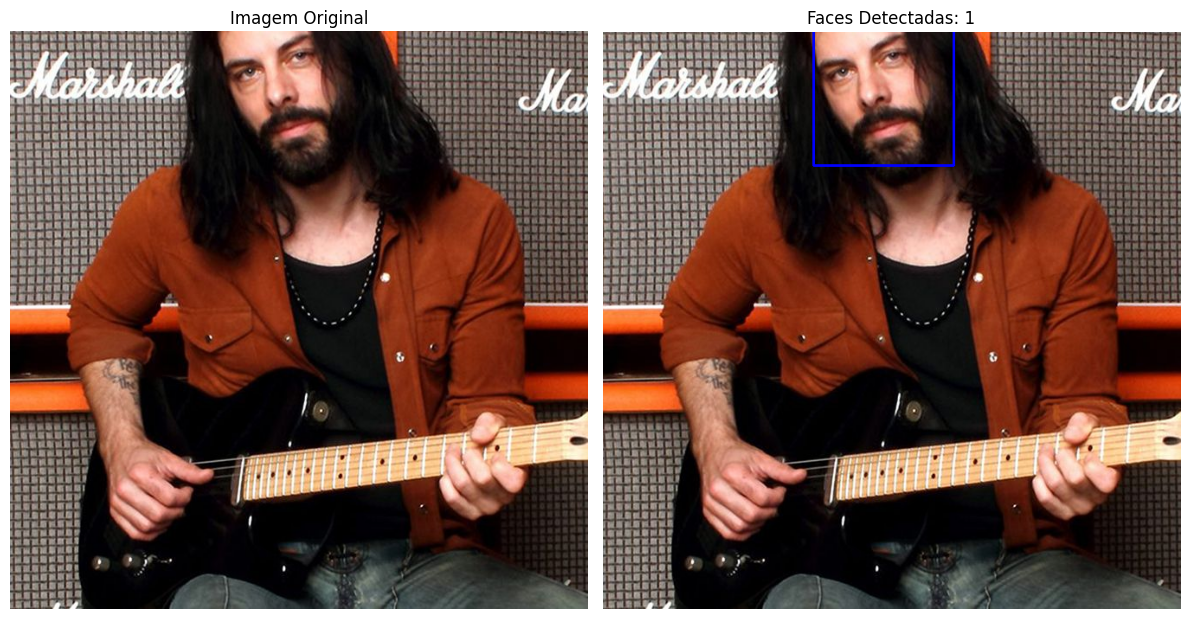

In [16]:
def quick_face_detection(image_path):
    """
    Função rápida para detectar faces em uma imagem
    """
    system = FaceRecognitionSystem()
    return system.process_image(image_path)

# Para usar rapidamente:
result = quick_face_detection('dataset/pessoa1/richie6.jpg')

# 🎓 Processo de Treinamento

## 📋 **Etapas do Treinamento:**
1. **Carregamento**: Lê todas as imagens das pastas
2. **Detecção**: Encontra e extrai as faces de cada imagem
3. **Aumento**: Cria variações de cada face (8x mais dados)
4. **Extração**: Converte cada face em embedding usando MobileNetV2
5. **Média**: Calcula embedding médio para cada pessoa
6. **Validação**: Testa consistência interna
7. **Salvamento**: Guarda embeddings e configurações

## 🧠 **MobileNetV2:**
- Rede neural pré-treinada no ImageNet
- Otimizada para ser rápida e eficiente
- Adaptada especificamente para reconhecimento facial

In [23]:
train_small_dataset()

=== SISTEMA OTIMIZADO PARA POUCOS DADOS ===

Para treinar o modelo, organize suas imagens da seguinte forma:
dataset/
├── pessoa1/
│   ├── foto1.jpg
│   ├── foto2.jpg
│   └── ...
├── pessoa2/
│   ├── foto1.jpg
│   └── ...
└── ...
Digite o caminho para o dataset (ou pressione Enter para usar './dataset'): 
Processando imagens de: John Petrucci
  - Encontradas 5 faces
Processando imagens de: .ipynb_checkpoints
  - Encontradas 0 faces
Processando imagens de: Richie Kotzen
  - Encontradas 5 faces

Total de faces coletadas: 10
Classes encontradas: {'Richie Kotzen', 'John Petrucci'}
=== TREINAMENTO COM AUMENTO DE DADOS ===

Dataset original: 10 → Aumentado: 81
Extraindo features das faces...
  ✅ John Petrucci: 45 faces processadas
  ✅ Richie Kotzen: 36 faces processadas

✅ Sistema treinado com 2 pessoas

🔍 Testando consistência interna...
    Similaridades: {'John Petrucci': 0.9993781, 'Richie Kotzen': 0.9992473}
    Melhor: John Petrucci = 0.999 → confiança: 1.000
  Real: John Petrucci | Pr

# ⚖️ Configuração do Threshold

## 🎯 **O que é o Threshold?**
É o "nível mínimo de certeza" para reconhecer alguém:
- **Alto (0.8)**: Só reconhece se tiver muita certeza (menos falsos positivos)
- **Baixo (0.3)**: Reconhece mesmo com pouca certeza (mais reconhecimentos)

## 🔄 **Auto-ajuste:**
O sistema testa suas fotos de treino e ajusta automaticamente:
- Calcula a confiança mínima das fotos conhecidas
- Define threshold em 80% desse valor
- Garante que suas fotos sejam sempre reconhecidas

## 🎨 **Códigos de Cor:**
- 🟢 **Verde**: Confiança > 80% (CERTO)
- 🟠 **Laranja**: Confiança > 60% (PROVÁVEL)  
- 🔴 **Vermelho**: Confiança > threshold (INCERTO)
- ⚫ **Cinza**: Confiança < threshold (DESCONHECIDO)

# 🚨 Problemas Comuns e Soluções

## ❌ **"Desconhecido" para fotos conhecidas:**
- **Causa**: Threshold muito alto
- **Solução**: Execute `fix_threshold_and_test()` para ajustar automaticamente

## ❌ **Confiança sempre 1.00:**
- **Causa**: Overfitting (modelo "decorou" as fotos)
- **Solução**: Use o sistema de embeddings (não redes neurais tradicionais)

## ❌ **Não detecta faces:**
- **Causa**: Faces muito pequenas ou mal iluminadas
- **Solução**: Use fotos com faces maiores e bem visíveis

## ❌ **Reconhece pessoa errada:**
- **Causa**: Faces muito parecidas ou poucas fotos de treino
- **Solução**: Adicione mais fotos variadas de cada pessoa

In [24]:
fix_threshold_and_test()

=== AJUSTANDO THRESHOLD E TESTANDO ===

✅ Embeddings carregados com sucesso!
Pessoas conhecidas: ['John Petrucci', 'Richie Kotzen']
🔧 Ajustando threshold...


# 🔍 Como Testar uma Nova Imagem

## 📊 **Processo de Teste:**
1. **Carregamento**: Sistema carrega embeddings salvos
2. **Detecção**: Encontra faces na nova imagem
3. **Extração**: Converte cada face em embedding
4. **Comparação**: Calcula similaridade com pessoas conhecidas
5. **Decisão**: Aplica threshold e decide quem é
6. **Visualização**: Mostra resultado com cores e confiança

## 📈 **Interpretando Resultados:**
- **Nome + alta confiança**: Sistema tem certeza
- **Nome + baixa confiança**: Sistema suspeita mas não tem certeza
- **"Desconhecido"**: Face não parece com ninguém conhecido

# ⚡ Uso Rápido do Sistema

## 🚀 **Para treinar:**
# Execute uma vez para treinar:
```train_small_dataset()```
## 🧪 Para testar:
```test_small_dataset_system('caminho/para/imagem.jpg')```
##🔧 Para ajustar threshold:
```fix_threshold_and_test()```

=== TESTANDO SISTEMA OTIMIZADO ===

✅ Embeddings carregados com sucesso!
Pessoas conhecidas: ['John Petrucci', 'Richie Kotzen']
📊 Threshold atual: 0.300
👥 Pessoas conhecidas: ['John Petrucci', 'Richie Kotzen']
    Similaridades: {'John Petrucci': 0.33720544, 'Richie Kotzen': 0.3375085}
    Melhor: Richie Kotzen = 0.338 → confiança: 0.669
  🎯 Face: Richie Kotzen (confiança: 0.669)


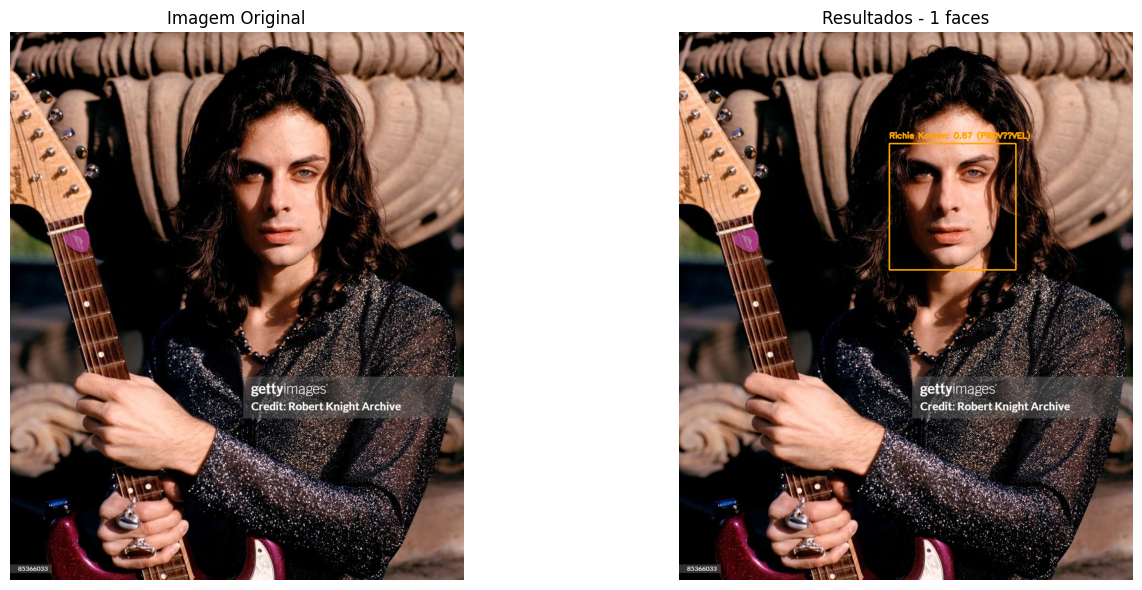

{'original_image': array([[[  8,   0,   0],
         [  8,   0,   0],
         [  6,   0,   1],
         ...,
         [ 73,  98, 142],
         [ 83, 109, 149],
         [ 89, 111, 152]],
 
        [[ 11,   3,   3],
         [ 10,   2,   2],
         [  7,   1,   2],
         ...,
         [ 58,  85, 129],
         [ 71,  96, 138],
         [ 77, 102, 142]],
 
        [[ 11,   3,   3],
         [ 10,   2,   2],
         [  7,   2,   1],
         ...,
         [ 44,  71, 115],
         [ 57,  82, 124],
         [ 64,  90, 130]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 58,  65,  90],
         [ 59,  66,  91],
         [ 59,  66,  91]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 60,  67,  92],
         [ 62,  69,  94],
         [ 62,  69,  94]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [

In [26]:
test_small_dataset_system('richie7.jpg')


---

## 📚 **11. CONCEITOS TÉCNICOS**
```markdown
# 🎓 Conceitos de Machine Learning Aplicados

## 🧠 **Transfer Learning:**
- Usamos MobileNetV2 pré-treinado no ImageNet
- Aproveitamos conhecimento de 14 milhões de imagens
- Adaptamos para reconhecimento facial específico

## 📊 **Feature Extraction:**
- Extraímos características importantes das faces
- 128 números que representam cada face unicamente
- Similar a "DNA" matemático de cada pessoa

## 🎯 **Similarity Learning:**
- Em vez de classificação tradicional, usamos similaridade
- Mais robusto para poucos dados
- Permite detectar pessoas "desconhecidas"

## 🔄 **Data Augmentation:**
- Aumenta dataset artificialmente
- Melhora generalização do modelo
- Reduz overfitting

---

# ✅ Por que Este Sistema Funciona Bem

## 🎯 **Para Datasets Pequenos:**
- Não precisa de centenas de fotos
- Funciona com 1-5 fotos por pessoa
- Usa transfer learning inteligente

## 🚀 **Performance:**
- Detecção rápida com MediaPipe
- Reconhecimento eficiente com embeddings
- Visualização automática dos resultados

## 🛡️ **Robustez:**
- Detecta pessoas desconhecidas
- Threshold auto-ajustável
- Resistente a variações de iluminação/ângulo

## 🔧 **Facilidade:**
- Uma linha para treinar
- Uma linha para testar
- Debug automático incluído